# Part1

In [43]:
from __future__ import unicode_literals

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties 

font = FontProperties(fname=r"/root/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/msyh.ttf")

import numpy as np

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis#CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import concordance_index_ipcw
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

True     963
False    142
Name: IsPlanned, dtype: int64


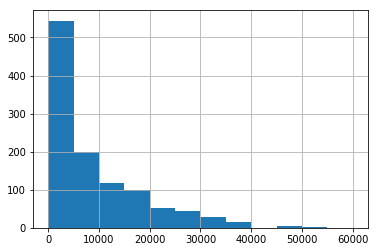

In [2]:
data1 = pd.read_csv("398908-3.csv", encoding = "GB2312")

#data1 = data1[data1["部件装上使用小时数"]!="00:00"]
data1["部件本次装机使用小时"] = data1["部件本次装机使用小时"].str.split(':').str[0].astype(int)
data1 = data1[data1["部件本次装机使用小时"]>0]

data1["IsPlanned"] = data1["非计划"]=="X"
print(data1["IsPlanned"].value_counts())
data_y = data1[["IsPlanned", "部件本次装机使用小时"]]
data_y["部件本次装机使用小时"].hist(bins=12, range=(0,60000))

data1["IsPlaneNew"] = data1["部件装上飞行小时数"]=="00:00"
data1["IsPartNew"] = data1["部件装上使用小时数"]=="00:00"
def CheckNew(p1,p2):
    if p1 and p2:
        return "PlaneNew-PartNew"
    elif p1 and not p2:
        return "PlaneNew-PartOld"
    elif not p1 and p2:
        return "PlaneOld-PartNew"
    elif not p1 and not p2:
        return "PlaneOld-PartOld"

#print([CheckNew(row["IsPlaneNew"], row["IsPartNew"]) for idx, row in data1.iterrows()])
data1["PlanePartType"] = [CheckNew(row["IsPlaneNew"], row["IsPartNew"]) for idx, row in data1.iterrows()]

data1["安装日期"] = pd.to_datetime(data1["安装日期"])
data1["安装年度"] = data1["安装日期"].dt.year

di = {"霍尼韦尔": "HONEYWELL"}
data1.replace({"最近送修公司": di}, inplace=True)
data1["最近送修公司"].fillna("Unknown", inplace=True)

data1["FH TSN"].fillna("00:00", inplace=True)
data1["部件装上飞行小时数"] = data1["部件装上飞行小时数"].str.split(':').str[0].astype(int)
data1["部件装上使用小时数"] = data1["部件装上使用小时数"].str.split(':').str[0].astype(int)

data1["部件装上飞行小时数-Range"] = pd.cut(data1['部件装上飞行小时数'], 8)
#data1["部件装上飞行循环数-Range"] = pd.cut(data1['部件装上飞行循环数'], 8)
data1["部件装上使用小时数-Range"] = pd.cut(data1['部件装上使用小时数'], 8)
#data1["部件装上使用循环数-Range"] = pd.cut(data1['部件装上使用循环数'], 8)
data1["CY TSN-Range"] = pd.cut(data1['CY TSN'], 8)
data1["FH TSN-Range"] = pd.cut(data1['FH TSN'], 8)

#data_x = data1[["机型","制造序列号","机号","参考类型","指令类型","序号","拆换原因","部件装上飞行循环数","部件装上使用循环数",
#                "部件拆下飞行循环数","部件拆下使用循环数","装上序号","最近送修公司","CY TSN","FH TSN"]]
#data_x = data1[["机型","参考类型","指令类型","拆换原因","部件装上飞行循环数","部件装上使用循环数",
#                "部件拆下飞行循环数","部件拆下使用循环数","CY TSN","FH TSN"]]
data_x = data1[["机型","安装年度","部件装上飞行小时数-Range","部件装上使用小时数-Range","FH TSN-Range", "最近送修公司","PlanePartType"]]

Text(0.5, 0, 'time $t$')

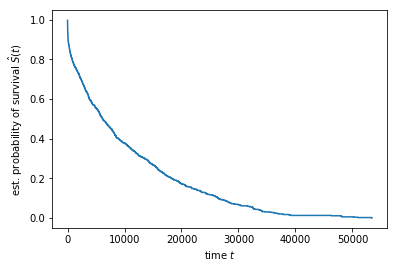

In [3]:
time, survival_prob = kaplan_meier_estimator(data_y["IsPlanned"], data_y["部件本次装机使用小时"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

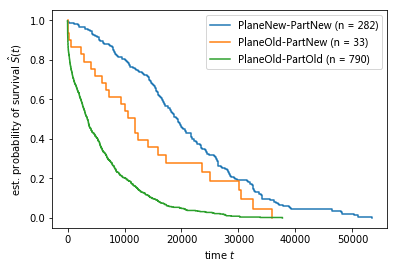

In [4]:
# "机型","拆换年度","部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range", "最近送修公司"
#col = "机型"
#col = "参考类型"
col = "PlanePartType"
#col = "安装年度"
#col = "机型"

#print((data_x["最近送修公司"]!="上海航新") & (data_x["最近送修公司"]!="PP"))

y = data_y
x = data_x

for value in x[col].unique():
    mask = x[col] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y["IsPlanned"][mask],
                                                           y["部件本次装机使用小时"][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right", prop=font)

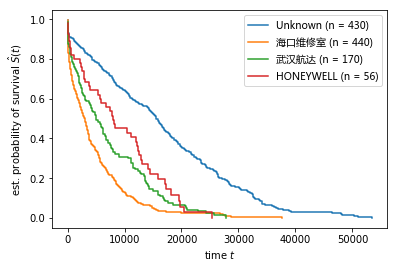

In [5]:
# "机型","拆换年度","部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range", "最近送修公司"
#col = "机型"
#col = "参考类型"
col = "最近送修公司"
#col = "安装年度"
#col = "机型"

#print((data_x["最近送修公司"]!="上海航新") & (data_x["最近送修公司"]!="PP"))

filter1 = (data_x["最近送修公司"]!="上海航新") & (data_x["最近送修公司"]!="PP") & (data_x["最近送修公司"]!="海航技术")
y = data_y[filter1]
x = data_x[filter1]

for value in x[col].unique():
    mask = x[col] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y["IsPlanned"][mask],
                                                           y["部件本次装机使用小时"][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right", prop=font)

In [6]:
#data_x.select_dtypes(exclude=['int','int64' 'float']).columns
data_x.describe()

,安装年度
count,1105.000000
mean,2010.716742
std,4.687358
min,1996.000000
25%,2008.000000
50%,2011.000000
75%,2015.000000
max,2018.000000


In [7]:
#"部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range",
#
x = data_x.copy()
cat_features = ["机型", "安装年度","部件装上飞行小时数-Range","部件装上使用小时数-Range","FH TSN-Range", "最近送修公司","PlanePartType"]

for col in cat_features:
    x[col] = x[col].astype('category')

data_x_numeric = OneHotEncoder().fit_transform(x[cat_features])
data_x_numeric.head()

,机型=73N,机型=73Q,安装年度=1997,安装年度=1998,安装年度=1999,安装年度=2000,安装年度=2001,安装年度=2002,安装年度=2003,安装年度=2004,...,"FH TSN-Range=(64256.732, 74960.606]","FH TSN-Range=(74960.606, 85664.48]",最近送修公司=PP,最近送修公司=Unknown,最近送修公司=上海航新,最近送修公司=武汉航达,最近送修公司=海口维修室,最近送修公司=海航技术,PlanePartType=PlaneOld-PartNew,PlanePartType=PlaneOld-PartOld
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [8]:
null_columns=data1.columns[data1.isnull().any()]
data1[null_columns].isnull().sum()

故障描述          285
故障处理            3
送修至拆下时间/FH    445
TLB号           11
dtype: int64

In [12]:
#data_y = data_y.as_matrix()
y = data_y.to_records(index=False)
estimator = CoxPHSurvivalAnalysis() #CoxnetSurvivalAnalysis()
estimator.fit(data_x_numeric, y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [13]:
#pd.Series(estimator.coef_, index=data_x_numeric.columns)

In [45]:
prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(y["IsPlanned"], y["部件本次装机使用小时"], prediction)
print(result[0])
result = concordance_index_ipcw(y, y, prediction)
print(result[0])

0.7553380581255218
0.7547391738249756


In [15]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxnetSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

PlanePartType=PlaneOld-PartOld           0.651442
最近送修公司=Unknown                           0.631788
最近送修公司=海口维修室                             0.616740
部件装上使用小时数-Range=(20298.5, 30447.75]      0.548653
部件装上飞行小时数-Range=(24571.125, 32761.5]     0.542170
部件装上使用小时数-Range=(10149.25, 20298.5]      0.538550
安装年度=2017                                0.536587
安装年度=2018                                0.534099
部件装上使用小时数-Range=(40597.0, 50746.25]      0.529255
安装年度=2016                                0.526942
部件装上飞行小时数-Range=(16380.75, 24571.125]    0.526721
部件装上飞行小时数-Range=(32761.5, 40951.875]     0.523604
部件装上使用小时数-Range=(30447.75, 40597.0]      0.523316
安装年度=2002                                0.520038
安装年度=2007                                0.516786
机型=73N                                   0.515876
安装年度=2015                                0.514370
部件装上使用小时数-Range=(50746.25, 60895.5]      0.513840
最近送修公司=武汉航达                              0.513777
安装年度=2009                                0.513556


In [40]:
x_new = data_x_numeric.loc[[46,77,200,593]]
#print(x_new)
data_x.loc[[46,77,200,593]]

,机型,安装年度,部件装上飞行小时数-Range,部件装上使用小时数-Range,FH TSN-Range,最近送修公司,PlanePartType
46,73N,2005,"(8190.375, 16380.75]","(20298.5, 30447.75]","(32145.111, 42848.985]",海口维修室,PlaneOld-PartOld
77,73N,2006,"(16380.75, 24571.125]","(10149.25, 20298.5]","(42848.985, 53552.859]",武汉航达,PlaneOld-PartOld
200,73C,2008,"(32761.5, 40951.875]","(10149.25, 20298.5]","(32145.111, 42848.985]",上海航新,PlaneOld-PartOld
593,73N,2013,"(16380.75, 24571.125]","(20298.5, 30447.75]","(53552.859, 64256.732]",海口维修室,PlaneOld-PartOld


In [41]:
y[[46,77,200,593]]

rec.array([( True, 39129), ( True,    49), ( True,  2884), (False,  6538)],
          dtype=[('IsPlanned', '?'), ('部件本次装机使用小时', '<i8')])

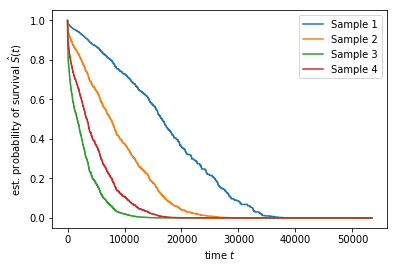

In [36]:
pred_surv = estimator.predict_survival_function(x_new)
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [19]:
pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [21]:
param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] -3)}
gcv = GridSearchCV(pipe, param_grid=param_grid, return_train_score=True, cv=3, iid=True)
gcv.fit(x, y)

pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: all coefficients are zero, consider decreasing alpha.
  import sys
/root/anaconda2/envs/python3

LinAlgError: Matrix is singular.

In [22]:
pipe.set_params(**gcv.best_params_)
pipe.fit(x, y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# Part2

In [46]:
from sklearn.model_selection import train_test_split
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

In [47]:
data_x = data1[["安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN"]]

In [48]:
def df_to_sarray(df):
    """
    Convert a pandas DataFrame object to a numpy structured array.
    This is functionally equivalent to but more efficient than
    np.array(df.to_array())

    :param df: the data frame to convert
    :return: a numpy structured array representation of df
    """

    v = df.values
    cols = df.columns

    if False:  # python 2 needs .encode() but 3 does not
        types = [(cols[i].encode(), df[k].dtype.type) for (i, k) in enumerate(cols)]
    else:
        types = [(cols[i], df[k].dtype.type) for (i, k) in enumerate(cols)]
    dtype = np.dtype(types)
    z = np.zeros(v.shape, dtype)
    for (i, k) in enumerate(z.dtype.names):
        z[:,i] = v[:, i]
    return z

In [49]:
y = data_y.to_records(index=False)
x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.2)#, random_state=1)
x_train = x_train.values
x_test = x_test.values

In [51]:
y_events_train = y_train[y_train['IsPlanned']==False]
train_min, train_max = y_events_train["部件本次装机使用小时"].min(), y_events_train["部件本次装机使用小时"].max()

y_events_test = y_test[y_test['IsPlanned']==False]
test_min, test_max = y_events_test["部件本次装机使用小时"].min(), y_events_test["部件本次装机使用小时"].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

In [52]:
times = np.percentile(data_y["部件本次装机使用小时"], np.linspace(5, 95, 15))
print(times)

[2.02000000e+01 1.18514286e+02 4.06142857e+02 9.61257143e+02
 1.85705714e+03 2.84934286e+03 3.76962857e+03 5.19400000e+03
 6.53765714e+03 8.26800000e+03 1.09074000e+04 1.40677429e+04
 1.68197143e+04 2.17654286e+04 2.87464000e+04]


In [53]:
import matplotlib
matplotlib.matplotlib_fname()

'/root/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'

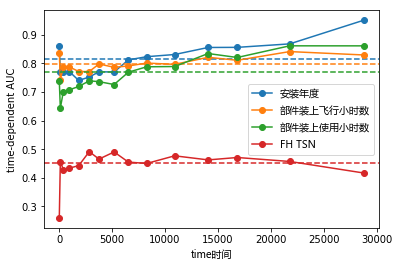

In [54]:
num_columns = ["安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN"]
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)
    
    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.legend(prop = font)
    
    plt.xlabel("time时间",fontproperties=font)
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")

    
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test[:, i], col, color="C{}".format(i))
    ret = concordance_index_ipcw(y_train, y_test, x_test[:, i], tau=times[-1])

# Part3

In [112]:
data_x = data1[["机型","安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN", "最近送修公司","PlanePartType"]]

cat_features = ["机型", "安装年度", "最近送修公司","PlanePartType"]

for col in cat_features:
    data_x[col] =data_x[col].astype('category')

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [165]:
times = np.percentile(data_y["部件本次装机使用小时"], np.linspace(5, 95, 15))
print(times)

[2.02000000e+01 1.18514286e+02 4.06142857e+02 9.61257143e+02
 1.85705714e+03 2.84934286e+03 3.76962857e+03 5.19400000e+03
 6.53765714e+03 8.26800000e+03 1.09074000e+04 1.40677429e+04
 1.68197143e+04 2.17654286e+04 2.87464000e+04]


In [ ]:
estimator = CoxPHSurvivalAnalysis() #CoxnetSurvivalAnalysis()
estimator.fit(data_x_numeric, y)

0.756783634038926
[24341 10021 11228     6   162   925  8692 13401     6  1736    94  3197
  7054 13193 24324  1243  2810  8395 12582 16474   452 15863 32718 32618
 15790    22    10 14395  5263 26845    13  5123     7  7852     6 13400
    15  6855  4764  5727 15920 13955  2382 15848  2098    40  8193  3853
 18057  5836  6109 17069  2205   315    98  2489  3099 13996  2281 30424
   609    65 15869  3877  1647  1935  3166 12358  4369 25760   537 23217
 21621    19   681 16516 24324 11413 37029 19146 17661 15757  2080    66
   170  7419 12465 18203 17153    12    93     8  2757 10922  2500 15018
  6041  2393 11133 28173   807 26479  2229  8509  3175 10559    25  4369
  5032 15454    38  3904  8059  7452 11100  2680    16 26662    18  4047
  1971 10175  8266   328  7472 20799 22579 23477  6925 32025   473  7593
 14913 38822  4118 15451   391  2984  5399   290    64    57    18  5916
  1930  4227  3023  6833 18239 35806   253  3149   244 29731 15255   605
    10 10321   427 15017  3450  6

AttributeError: 'Pipeline' object has no attribute 'predict_survival_function'

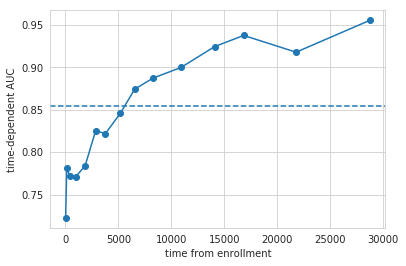

In [171]:
from sklearn.pipeline import make_pipeline

y = data_y.to_records(index=False)

x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.2)#, random_state=1)

cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(x_train, y_train)

result = concordance_index_censored(y_test["IsPlanned"], y_test["部件本次装机使用小时"], cph.predict(x_test))
print(result[0])

# estimate performance on training data, thus use `va_y` twice.
va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph.predict(x_test), times)

plt.plot(times, va_auc, marker="o")
plt.axhline(va_mean_auc, linestyle="--")
plt.xlabel("time from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

print(y_test["部件本次装机使用小时"])
print(cph.predict_survival_function(x_test))
print(y_test["部件本次装机使用小时"] - cph.predict(x_test))

# Part4

In [130]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")

In [131]:
data_x = data1[["机型","安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN", "最近送修公司","PlanePartType"]]

cat_features = ["机型", "安装年度", "最近送修公司","PlanePartType"]

for col in cat_features:
    data_x[col] = data_x[col].astype('category')

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [159]:
x = OneHotEncoder().fit_transform(data_x)#encode_categorical(data_x)

In [160]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)#, random_state=1)
estimator = FastSurvivalSVM(optimizer="rbtree",rank_ratio=0.0, max_iter=1000, tol=1e-6, random_state=0, alpha=2.**-6)
estimator.fit(x_train, y_train)

FastSurvivalSVM(alpha=0.015625, fit_intercept=False, max_iter=1000,
        optimizer='rbtree', random_state=0, rank_ratio=0.0, timeit=False,
        tol=1e-06, verbose=False)

In [161]:
prediction = estimator.predict(x_test)
result = concordance_index_censored(y_test["IsPlanned"], y_test["部件本次装机使用小时"], prediction)
print(result[0])

0.5744231561598682


In [162]:
estimator.predict(x_train)

array([3.80798839e+04, 1.17224212e+05, 2.58471438e+00, 3.90151964e+03,
       1.37620326e+01, 1.28918585e+02, 1.82483675e+02, 6.77225783e+01,
       4.98668826e+01, 7.47552252e+02, 5.81953136e+01, 4.48475905e+02,
       4.80917787e+01, 7.26665835e+03, 5.58728388e+01, 3.90171909e+02,
       4.92458309e+02, 1.62738487e+01, 1.72644681e+03, 3.68704384e+03,
       2.90190206e+00, 4.33967128e+04, 1.27270915e+01, 2.05282568e+03,
       2.15057752e+02, 2.03550200e+01, 4.66880718e+03, 1.03293408e+03,
       1.55666273e+02, 9.51705672e+01, 3.32296128e+01, 8.43293679e+01,
       1.22491744e+03, 3.69915810e+00, 7.10670414e+02, 3.94242404e+01,
       6.00051478e+00, 1.30702851e+02, 9.75539791e+04, 9.07778085e+04,
       2.50752172e+03, 6.40670491e+03, 1.22472558e+02, 3.04171670e+03,
       6.01351139e+01, 6.36606102e+02, 6.86529186e+02, 1.41367543e+03,
       6.60681833e+02, 1.03273870e+04, 6.19720198e+04, 8.85110488e+03,
       1.26446042e+03, 1.34748528e+04, 8.11509228e+03, 7.97379837e+02,
      

In [61]:
estimator = FastSurvivalSVM(optimizer="rbtree", max_iter=1000, tol=1e-6, random_state=0)

In [62]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['IsPlanned'], y['部件本次装机使用小时'], prediction)
    return result[0]

In [63]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=20, test_size=0.4, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model,
                   n_jobs=12, iid=False, refit=False,
                   cv=cv)

In [64]:
param_grid

{'alpha': array([2.44140625e-04, 9.76562500e-04, 3.90625000e-03, 1.56250000e-02,
        6.25000000e-02, 2.50000000e-01, 1.00000000e+00, 4.00000000e+00,
        1.60000000e+01, 6.40000000e+01, 2.56000000e+02, 1.02400000e+03,
        4.09600000e+03])}

In [65]:
import warnings
y = data_y.to_records(index=False)
warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x, y)

In [66]:
gcv.best_score_, gcv.best_params_

(0.687600449121407, {'alpha': 0.000244140625})

In [67]:
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):            
        name = "%.5f" % params["alpha"]
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_["split%d_test_score" % j][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pandas.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

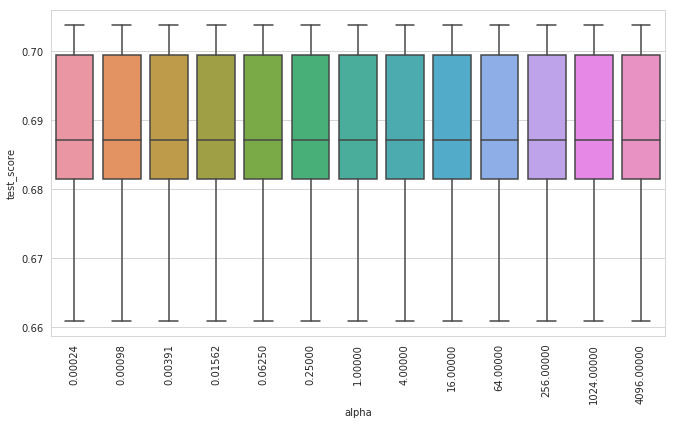

In [68]:
plot_performance(gcv)

In [106]:
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.kernels import clinical_kernel

In [107]:
x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.5)#, random_state=1)
kernel_matrix = clinical_kernel(x_train)
kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0, alpha=2.**-6)
kssvm.fit(kernel_matrix, y_train)

FastKernelSurvivalSVM(alpha=0.015625, coef0=1, degree=3, fit_intercept=False,
           gamma=None, kernel='precomputed', kernel_params=None,
           max_iter=20, optimizer='rbtree', random_state=0, rank_ratio=1.0,
           timeit=False, tol=None, verbose=False)

In [108]:
x_test.shape

(553, 7)

In [109]:
kernel_matrix = clinical_kernel(x_test[0:552])
prediction = kssvm.predict(kernel_matrix)
result = concordance_index_censored(y_test[0:552]["IsPlanned"], y_test[0:552]["部件本次装机使用小时"], prediction)
print(result[0])

0.6438882846429413


In [70]:
kernel_matrix = clinical_kernel(data_x)
kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0, alpha=2.**-12)

In [71]:
kgcv = GridSearchCV(kssvm, param_grid, score_survival_model,
                    n_jobs=12, iid=False, refit=False,
                    cv=cv)

In [72]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
kgcv = kgcv.fit(kernel_matrix, y)

KeyboardInterrupt: 

In [ ]:
kgcv.best_score_, kgcv.best_params_

In [ ]:
plot_performance(kgcv)